In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import drs_sentani as sti
survey = sti.get_survey()
# set display format for tables
pd.set_option('display.float_format', lambda x: '%.2e' % x)

To show the spending in off-grid areas, I create a variable ``composite_expenditure`` that sums the monthly costs for 

- PLN expenditure
- Community microgrid expenditure
- Genset expenditure
- Mobile phone charging
- Lighting from non-electric sources

There is some ambiguity in how the households interpreted the frequency of genset spending.  The genset expenditure monthly calculation assumes that the daily value provided in the survey is spent every day.  In future work, we could add a question on the frequency of use of the generator to be sure our estimates are more accurate.

In our averages, we calculate the average expenditure for all reporting households as opposed to the average expenditure only for households reporting that expenditure.

In [2]:
# create derived columns for monthly expenditures
survey['PLN_expenditure_monthly'] = survey['PLN_expenditure']
survey['community_microgrid_expenditure_monthly'] = survey['community_microgrid_expenditure']
survey['genset_expenditure_monthly'] = survey['genset_expenditure'] * 365.25 / 12

# adjust HP to monthly assuming charging frequency is reported per week
survey['HP_monthly'] = survey['HP_charging_price'] * survey['HP_charging_frequency'] * 52 / 12

# adjust lighting to monthly assuming reporting per week
survey['lighting_monthly'] = survey['non_electrice_light_expenditures'] * 52 / 12

# create access type column
survey['access_type'] = sti.access_type(survey)

# sum energy expenditure values into a meta-variable
survey['composite_expenditure'] = survey[['genset_expenditure_monthly',
                                          'HP_monthly',
                                          'lighting_monthly']].sum(axis=1)

# put data in long-form to facilitate aggregations
expenditure_long = pd.melt(survey, 
                           id_vars=['access_type', 'village_name'], 
                           value_vars=['genset_expenditure_monthly',
                                       'HP_monthly',
                                       'lighting_monthly',
                                       'composite_expenditure'])

In [3]:
# replace null values with zeros so that mean is over all households
expenditure_zeroed = expenditure_long.fillna(0)

# here I aggregate only over the meta-variable
off_grid = expenditure_zeroed[expenditure_zeroed['access_type']=='no_access']

#off_grid = off_grid[off_grid['variable']=='composite_expenditure']
output = off_grid.groupby(['village_name','variable']).agg(['mean', 'median', 'std', 'count'])
output.to_excel('off-grid-composite.xlsx')
output

value                        
                                            mean   median      std count
village_name variable                                                   
Abar         HP_monthly                 2.77e+04 0.00e+00 7.79e+04    46
             composite_expenditure      9.04e+05 4.66e+05 1.31e+06    46
             genset_expenditure_monthly 4.50e+05 0.00e+00 1.04e+06    46
             lighting_monthly           4.27e+05 2.17e+05 5.44e+05    46
Ebunfauw     HP_monthly                 0.00e+00 0.00e+00 0.00e+00    36
             composite_expenditure      8.26e+05 6.95e+05 6.26e+05    36
             genset_expenditure_monthly 7.52e+05 6.09e+05 6.02e+05    36
             lighting_monthly           7.34e+04 4.33e+04 7.74e+04    36
Kalio        HP_monthly                 0.00e+00 0.00e+00 0.00e+00    30
             composite_expenditure      5.79e+05 2.17e+05 6.68e+05    30
             genset_expenditure_monthly 4.67e+05 0.00e+00 6.72e+05    30
             lighting_monthly           1.13e+05 8.67e+04 9.08e+04    30
Kampung_Baru HP_monthly                 0.00e+00 0.00e+00 0.00e+00    36
             composite_expenditure      1.08e+06 9.67e+05 8.30e+05    36
             genset_expenditure_monthly 9.74e+05 9.13e+05 8.18e+05    36
             lighting_monthly           1.02e+05 8.67e+04 7.59e+04    36
Khageuw      HP_monthly                 2.71e+03 0.00e+00 1.08e+04    16
             composite_expenditure      6.14e+05 2.82e+05 6.93e+05    16
             genset_expenditure_monthly 5.33e+05 1.52e+05 6.99e+05    16
             lighting_monthly           7.85e+04 4.33e+04 6.17e+04    16
Obolyo       HP_monthly                 1.58e+04 0.00e+00 5.23e+04    11
             composite_expenditure      6.86e+05 4.33e+05 8.65e+05    11
             genset_expenditure_monthly 0.00e+00 0.00e+00 0.00e+00    11
             lighting_monthly           6.70e+05 4.33e+05 8.15e+05    11
Puai         HP_monthly                 0.00e+00 0.00e+00 0.00e+00    74
             composite_expenditure      1.30e+06 9.15e+05 1.33e+06    74
             genset_expenditure_monthly 8.17e+05 6.09e+05 1.03e+06    74
             lighting_monthly           4.85e+05 2.17e+05 6.90e+05    74
Yoboi        HP_monthly                 2.89e+04 0.00e+00 9.90e+04    49
             composite_expenditure      6.36e+05 6.52e+05 4.66e+05    49
             genset_expenditure_monthly 4.22e+05 6.09e+05 4.34e+05    49
             lighting_monthly           1.85e+05 1.30e+05 3.17e+05    49
Yokiwa       HP_monthly                 0.00e+00 0.00e+00 0.00e+00    43
             composite_expenditure      5.91e+05 2.17e+05 6.29e+05    43
             genset_expenditure_monthly 4.32e+05 0.00e+00 6.10e+05    43
             lighting_monthly           1.59e+05 1.30e+05 1.09e+05    43

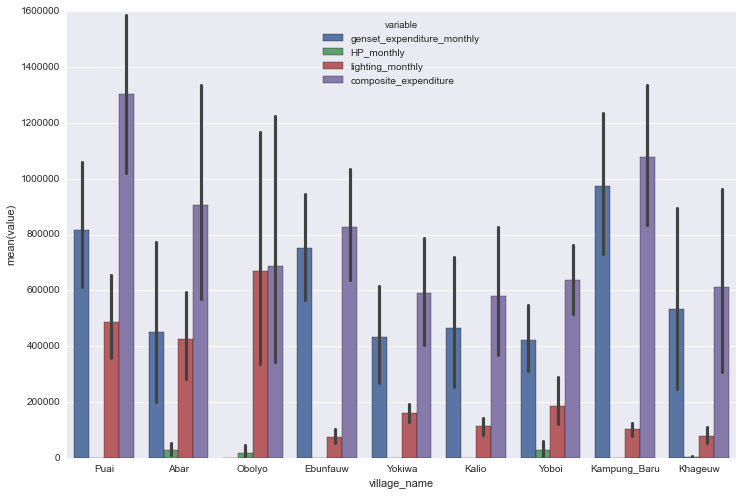

In [4]:
plt.figure(figsize=(12, 8))
sns.barplot(data=off_grid, x='village_name', y='value', hue='variable', estimator=np.mean)

In [5]:
off_grid[off_grid['variable']=='composite_expenditure']['value'].describe()

count   3.41e+02
mean    8.73e+05
std     9.78e+05
min     0.00e+00
25%     1.52e+05
50%     6.74e+05
75%     1.30e+06
max     7.39e+06
Name: value, dtype: float64